In [486]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline



## 1. Problem definition

The main goal of this project is to predict whether a customer will leave the company or not --> 2 desicions --> binary classification

The model is trained with customer data and labels. For that we'll be using supervised learning. 
It’s important to notice that the outcome is uncertain and based on probability.  

> How does the company expect to use and benefit from this model?

Customer churn is a huge issue for businneses and therefore should be an priority. 
Churn prevention allows companies to develop loyalty programs and retention campaigns to keep as many customers as possible. Knowing which customer is about to churn (i.e., stop doing business or end the relationship with the company) is valuable information.

The goal of this Notebook is to predict whether a customer is about to churn. By using machine learning techniques, we can identify patterns and characteristics of customers who are likely to churn, and use this information to proactively address customer concerns and improve retention

## 2. Data

In [487]:
df = pd.read_csv('Bank_Churn_Data.csv', index_col='RowNumber')
df.shape, df.columns

((10000, 13),
 Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
        'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
        'EstimatedSalary', 'Exited'],
       dtype='object'))

In [488]:
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,,,
1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [489]:
df.nunique()

CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

### Data Set:

- We are working with structured and static data. 
- It consists of 10000 observations and 12 variables.
- The deependent variable refers to the customer abandonment.

### Features:

- CustomerId
- Surname
- CreditScore
- Geography: Country (Germany / France / Spain)
- Gender: Female / Male
- Age
- Tenure: How many years of customer ([0, 11])
- Balance
- NumOfProducts: Bank product used ([0, 4])
- HasCrCard: Credit card status (0 = No, 1 = Yes)
- IsActiveMember: Active membership status (0 = No, 1 = Yes)
- EstimatedSalary
- Exited: Abandoned or not? (0 = No, 1 = Yes)

## 3. Evaluation

Metrics for the classification problem: accuray and precion/recall (confusion matrix) important.

The main purpose of this task is to identify as many churned customers as possible. The more, the better. Therefore, recall is the most important. 
Recall refers to the number of churned customers identified by the model divided by the total number of customers who have actually churned, as expressed in formula: Recall = True Positive / (True Positive + False Negative).

## 4. Understanding Features / Exploratory data analysis (EDA)

Next we will have a look on the dataset and get familiar with it. 

RowNumber and CustomerID could be removed as both are specific to a customer and fail to provide value-added information in identifying potential customers who churned. Surname is likely to cause profiling, thus preferably to be excluded. Exited column is target variable.

In [490]:
df = df.drop(["CustomerId","Surname"], axis=1)

In [491]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 937.5+ KB


 There are no missing values. So we dont have to hande missing values in this case. Next, we check proportion of customer churned and retained.

In [492]:
target_count = df["Exited"].value_counts(normalize=True)
target_count

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

We can see that around 20% of customers in the dataset churned, which sets a baseline for the models to identify at least 20% of customers as churners. To improve this, we can try to handle the class imbalance issue using SMOTE (Synthetic Minority Over-sampling Technique). Since the churned customers make up only a minority of the dataset, SMOTE will generate synthetic examples of the minority class (churners) to balance the dataset, which can help the model to better learn the patterns associated with customer churn.

Next try to understand the features by statistcs and some graphics.

In [493]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


ValueError: invalid literal for int() with base 10: '_nolegend_'

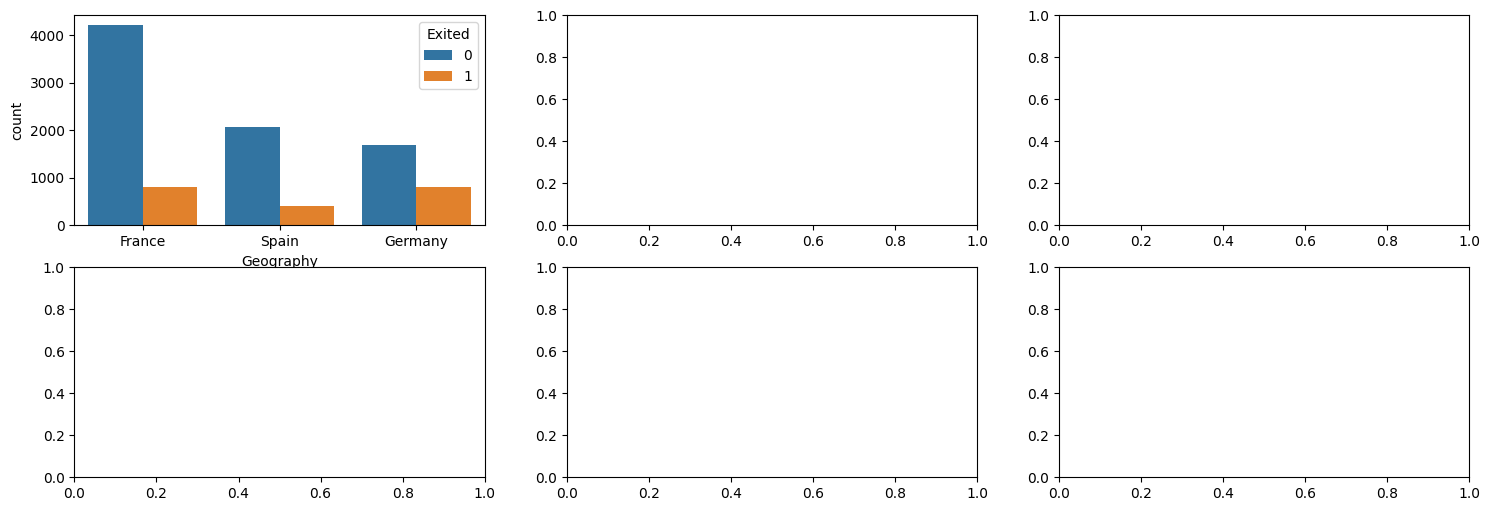

In [494]:
import seaborn as sns
import matplotlib.pyplot as plt

def show_categorical_features(df):
    fig, axarr = plt.subplots(2, 3, figsize=(18, 6))

    # List of categorical columns to loop through
    categorical_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure']

    for i, col in enumerate(categorical_columns):
        ax = axarr[i//3, i%3]  # Determine the position for the subplot
        sns.countplot(x=col, hue='Exited', data=df, ax=ax)

        # Calculate the percentages for each category in the current column
        category_counts = df.groupby([col, 'Exited']).size().unstack(fill_value=0)
        category_percentages = category_counts.div(category_counts.sum(axis=1), axis=0) * 100

        # Add percentage labels on the bars
        for p in ax.patches:
            height = p.get_height()
            width = p.get_width()
            x = p.get_x() + width / 2  # Position of the label
            y = p.get_height()  # Position of the label
            
            # Get the category (x-axis) and the hue label (Exited 0 or 1)
            category_idx = int(p.get_x() // width)  # Which category the bar corresponds to
            hue_label = int(p.get_label())  # Which hue label (0 or 1) the bar corresponds to

            # Get the percentage for this category and hue label
            category_label = ax.get_xticklabels()[category_idx].get_text()
            percentage = category_percentages.loc[category_label, hue_label]
            
            # Add the percentage as text on the bar
            ax.text(x, y + 5, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

# Assuming 'df' is your DataFrame
show_categorical_features(df)


In [ ]:
df[str('NumOfProducts')]["Exited"].count()


KeyError: 'Exited'

In [ ]:
filtered_count = df[(df['NumOfProducts'] == 4) & (df['Exited'] == 0)].shape[0]

df[(df(featur e== cats)

# Zeige das gefilterte Ergebnis
print(filtered_count)


0


[1 3 2 4] [1 0]


TypeError: only integer scalar arrays can be converted to a scalar index

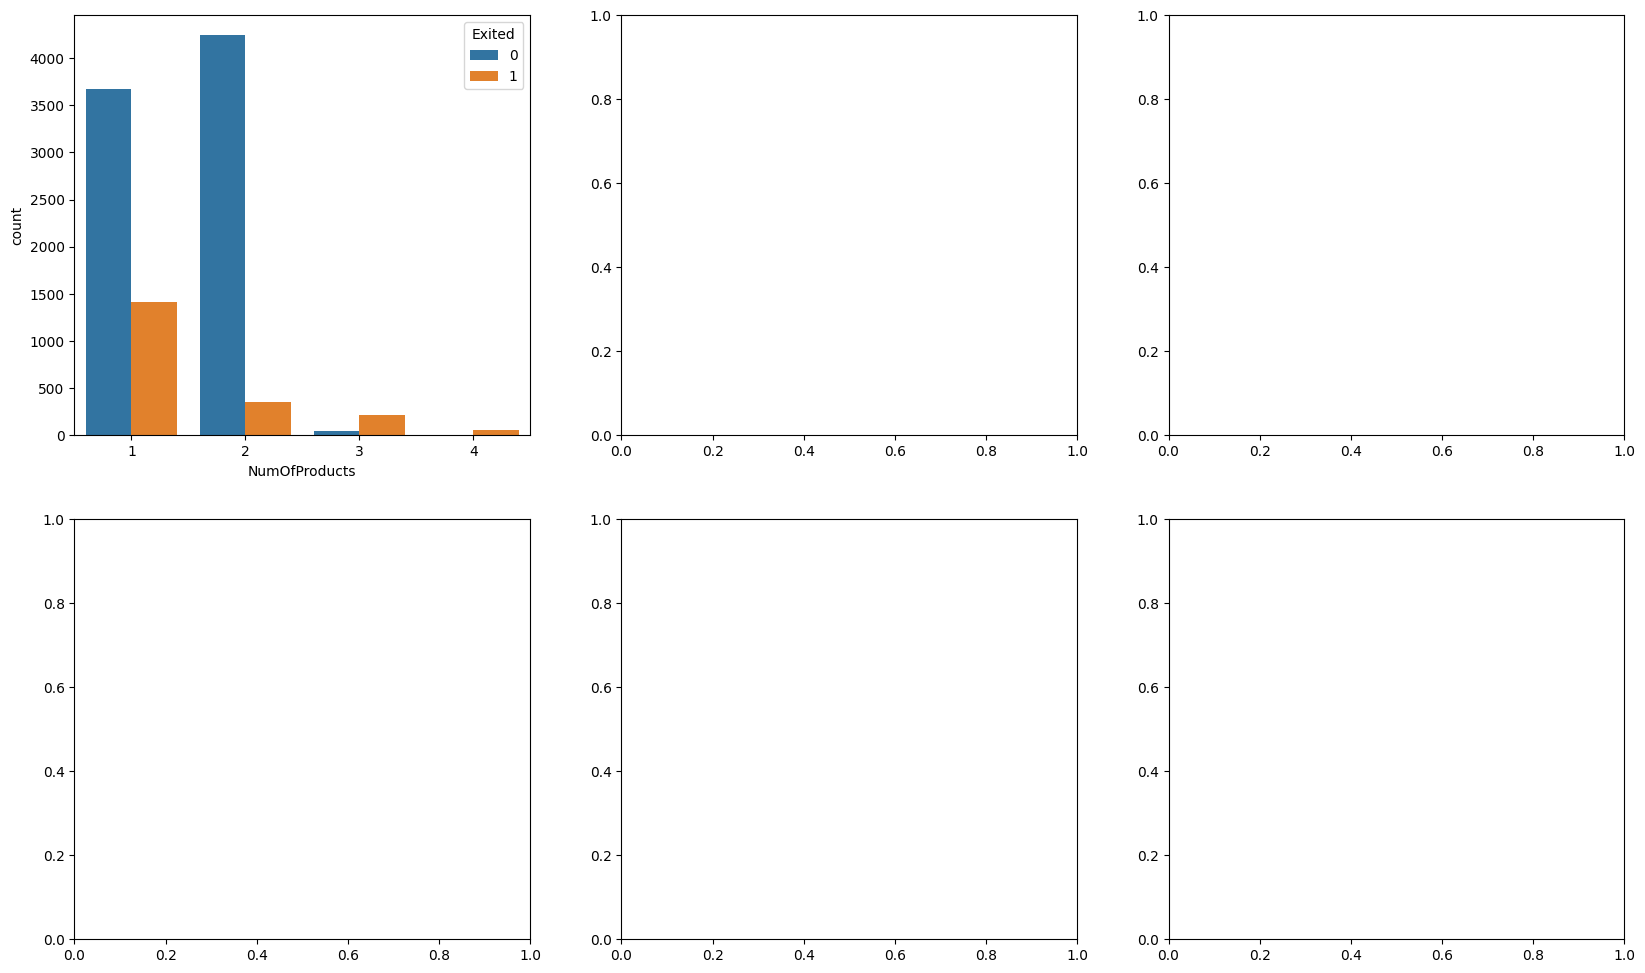

In [511]:
# Third, let's review target variable's relationship with categorical features
_,axss = plt.subplots(2,3, figsize=[20,12])
categorical_val=['NumOfProducts', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Tenure']

# Define a function to add percentage on top of bars
def with_hue(plot, feature, number_of_categories, hue_categories):

    # get batches from graph
    a = [p.get_height() for p in plot.patches]
    patch=[p for p in plot.patches]
    #print(a)
    abc = 0   
    for i in range(hue_categories):

        for j in range(num_of_categories):
            
        
            # specify which category to annotate
            cats = np.sort(feature.unique())[j]
            
            # total counts of the category
            total = df[feature==cats]["Exited"].count()
            #print(df[feature == cats  ])
            
            print(df[(df[feature==cats] == 4)].shape[0])
             
            #filtered_count = df[(df['NumOfProducts'] == j + 1) & (df['Exited'] == i)].shape[0]
            #filtered_count = df[df[feature==cats] & (df['Exited'] == i)].shape[0]     
            # get the index of which patch to annotate 
            id = i * num_of_categories + j
            # get the value corresponding to the patch
            #number = a[id]
            filtered_count = df[(df['NumOfProducts'] == j + 1) & (df['Exited'] == i)].shape[0]
            print(cats, total, filtered_count, filtered_count/total)
            # get proportion of the patch in the category it belongs to 
            pct= "{:.2f}%".format(round(100*(filtered_count/total),2))
            #print(pct, a[id], total, a[id]/total)
    
            # get x, y coordinate of annotation
            if filtered_count != 0:
                #continue
                x = patch[id-abc].get_x() + patch[id-abc].get_width()/ 2 - 0.15
                y = patch[id-abc].get_y() + patch[id-abc].get_height()
                plot.annotate(pct, (x, y), size=7)
            # else:
            #     abc += 1
           

for i, n in enumerate(categorical_val):
    ax_=axss[i//3][i%3]
    sns.countplot(x=n, hue="Exited", data=df, ax=ax_)      
    num_of_categories = df[str(n)].unique()
    hue_categories = df["Exited"].unique()
    #with_hue(ax_, df[str(n)], num_of_categories, hue_categories)
    print(num_of_categories, hue_categories)
    
    for i in range(hue_categories):
        for j in range(num_of_categories):
            filtered_count = df[(df[str(n)] == num_of_categories[i]) & (df['Exited'] == hue_categories[j])].shape[0]
    
    
plt.show()
hue_categories, num_of_categories
n

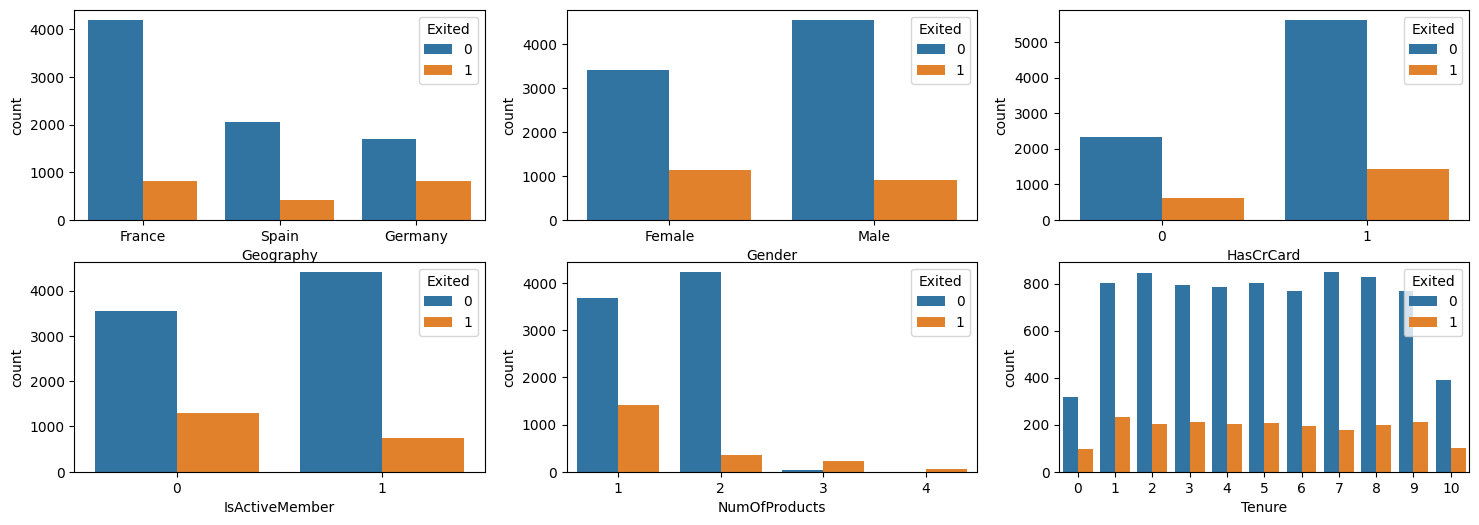

In [ ]:

def show_dependent_variable(df):
    fig, axarr = plt.subplots(2, 3, figsize=(18, 6))
    sns.countplot(x = 'Geography', hue = 'Exited',data = df, ax = axarr[0][0])
    sns.countplot(x = 'Gender', hue = 'Exited',data = df, ax = axarr[0][1])
    sns.countplot(x = 'HasCrCard', hue = 'Exited',data = df, ax = axarr[0][2])
    sns.countplot(x = 'IsActiveMember', hue = 'Exited',data = df, ax = axarr[1][0])
    sns.countplot(x = 'NumOfProducts', hue = 'Exited',data = df, ax = axarr[1][1])
    sns.countplot(x = 'Tenure', hue = 'Exited',data = df, ax = axarr[1][2])
    
show_dependent_variable(df)

In [ ]:
def show_numeric_features(df):
    fig, axarr = plt.subplots(2, 2, figsize=(18, 6))
    sns.histplot(x = 'Age', hue = 'Exited',data = df, ax = axarr[0][0], kde=True)
    sns.histplot(x = 'Balance', hue = 'Exited',data = df, ax = axarr[0][1], kde=True)
    sns.histplot(x = 'EstimatedSalary', hue = 'Exited',data = df, ax = axarr[1][0], kde=True)
    sns.histplot(x = 'CreditScore', hue = 'Exited',data = df, ax = axarr[1][1], kde=True)

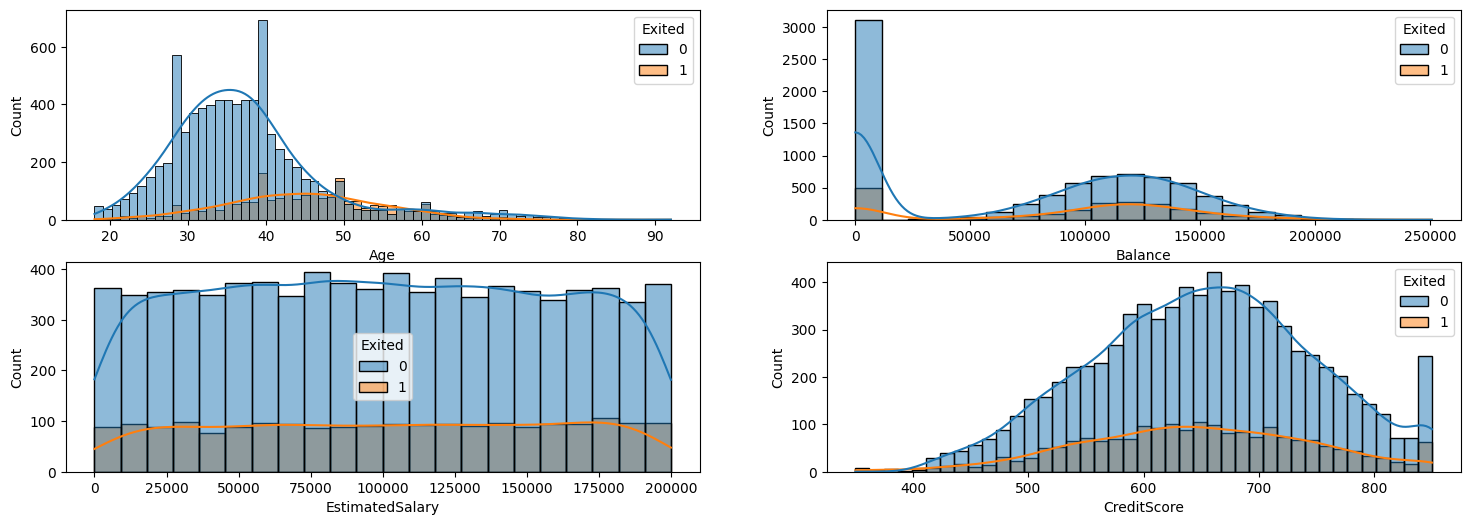

In [ ]:
show_numeric_features(df)

In [ ]:
sns.histplot(data=df, kde=True,hue="Exited")

ValueError: The following variable cannot be assigned with wide-form data: `hue`

1 5084 3675 0.7228560188827695
2 4590 4242 0.9241830065359478
3 266 46 0.17293233082706766
4 60 0 0.0
1 5084 1409 0.27714398111723054
2 4590 348 0.07581699346405228
3 266 220 0.8270676691729323
4 60 60 1.0
France 5014 4204 0.8384523334662943
Germany 2509 1695 0.6755679553607015
Spain 2477 2064 0.8332660476382721
France 5014 810 0.16154766653370561
Germany 2509 814 0.32443204463929853
Spain 2477 413 0.1667339523617279
Female 4543 3404 0.7492846136913933
Male 5457 4559 0.8354407183434122
Female 4543 1139 0.2507153863086066
Male 5457 898 0.16455928165658787
0 2945 2332 0.7918505942275043
1 7055 5631 0.798157335223246
0 2945 613 0.20814940577249574
1 7055 1424 0.20184266477675408
0 4849 3547 0.7314910290781604
1 5151 4416 0.8573092603377985
0 4849 1302 0.26850897092183956
1 5151 735 0.14269073966220153
0 413 318 0.7699757869249395
1 1035 803 0.7758454106280194
2 1048 847 0.808206106870229
3 1009 796 0.7888999008919723
4 989 786 0.7947421638018201
5 1012 803 0.7934782608695652
6 967 771 0.7

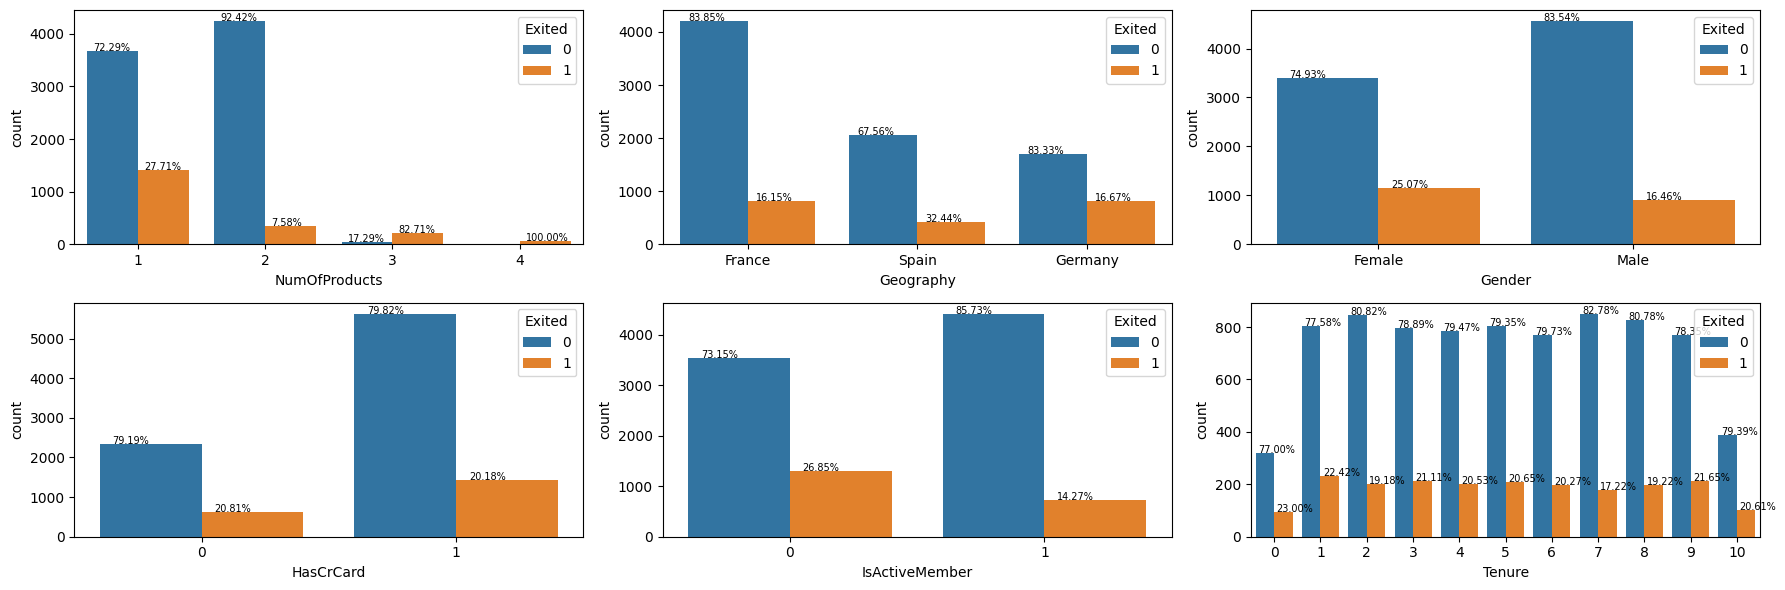

In [ ]:
def with_hue(plot, feature, df):
    patch = [p for p in plot.patches]
    
    feature_categories = np.sort(df[feature].unique())
    exited_categories = np.sort(df['Exited'].unique())
    
    abc = 0
    for i in exited_categories:
        for j, cats in enumerate(feature_categories):

            total = df[df[feature] == cats]["Exited"].count()

            if total > 0:
                filtered_count = df[(df[feature] == cats) & (df['Exited'] == i)].shape[0]

                pct = "{:.2f}%".format(round(100 * (filtered_count / total), 2))

                if filtered_count != 0:
                    patch_index = j + i * len(feature_categories)  # Make sure it's an integer index
                    x = patch[patch_index-abc].get_x() + patch[patch_index-abc].get_width() / 2 - 0.15
                    y = patch[patch_index-abc].get_y() + patch[patch_index-abc].get_height()
                    plot.annotate(pct, (x, y), size=7)
                else:
                    abc += 1
                    
def show_dependent_variable(df):
    fig, axarr = plt.subplots(2, 3, figsize=(18, 6))
    categorical_val = ["NumOfProducts", "Geography", "Gender", "HasCrCard", "IsActiveMember", "Tenure"]

    for i, n in enumerate(categorical_val):
        ax_ = axarr[i // 3][i % 3]
        sns.countplot(x = n, hue="Exited", data=df, ax=ax_)
        with_hue(ax_, str(n), df)

    plt.tight_layout()
    plt.show()

show_dependent_variable(df)


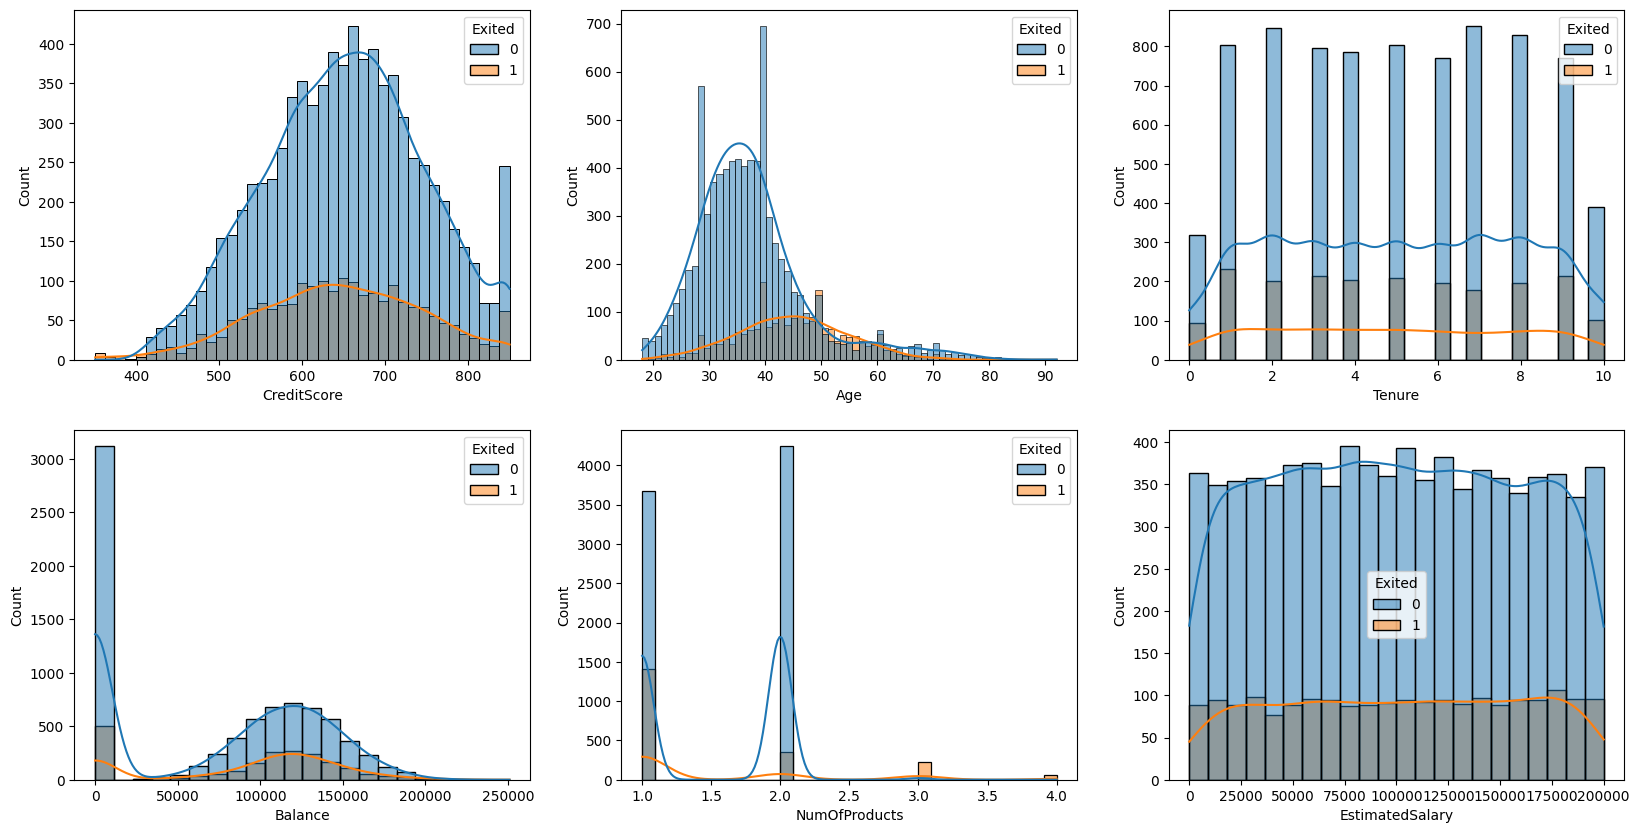

In [543]:
# Second, let's review target variable's relationship with numeric varaibles
_,axss = plt.subplots(2,3, figsize=[20,10]) 
numeric_val=["CreditScore","Age","Tenure","Balance","NumOfProducts","EstimatedSalary"]
for i, n in enumerate(numeric_val):
    #sns.boxplot(x='Exited', y =n, notch=True, data=df, )
    sns.histplot(data=df, x=n, kde=True,hue="Exited", ax=axss[i//3][i%3])
    sns.countplot(x=n, hue="Exited", data=df, ax=ax_)
    for line in axss[0][0].get_lines()[4::12]:
        line.set_color('yellow')
    for line in axss[0][0].get_lines()[10::12]:
        line.set_color('yellow')

show_dependent_variable(df)

df.summary

Wait! Before you look at the data any further, you need to create a test set, put it aside, and never look at it. <br>
Q: Why should you do this at this stage?

In [544]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

len(X), len(X_train), len(X_test)

NameError: name 'X' is not defined

## Exploratory data analysis (EDA)

Next have a look on the dataset and get familiar with it. 

